In [66]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
case_data = pd.read_csv("../data/case.csv", index_col=False)
print(case_data.shape)
tenacy_data = pd.read_csv("../data/tenancy.csv", index_col=False)
print(tenacy_data.shape)
vulnerability_data = pd.read_csv("../data/vulnerability.csv", index_col=False)
print(vulnerability_data.shape)

(46301, 7)
(11102, 4)
(4315, 2)


# Vulnerability

In [3]:
# Vulnerability
vulnerability_data
print("There are {} tenants in our database".format(vulnerability_data['tenancy_id'].drop_duplicates().shape[0]))
print("Each tenant can have more than one vulnerability")
vulnerability_data['Vulnerability'].value_counts()

There are 2683 tenants in our database
Each tenant can have more than one vulnerability


Illness                  914
Physical Support         668
Mental Health            538
Elderly                  391
COVID Self Isolation     299
Tenancy Support          211
Caution                  173
Wheelchair Support       171
Language Support         166
Learning difficulties    156
Tenancy Verification     139
Sight                    136
COVID 12wk Shielding     125
Hearing                  111
Domestic Violence         53
Drug/Alcohol              51
Young Person              11
Child Protection           2
Name: Vulnerability, dtype: int64

In [4]:
vulnerability_data

,tenancy_id,Vulnerability
0,Tenant5019,Physical Support
1,Tenant3085,Domestic Violence
2,Tenant1404,Illness
3,Tenant1801,Illness
4,Tenant2370,Elderly
...,...,...
4310,Tenant8205,Illness
4311,Tenant6328,Illness
4312,Tenant5785,COVID Self Isolation
4313,Tenant9018,Physical Support


In [5]:
vulnerability_data_packed = vulnerability_data.groupby(['tenancy_id'])['Vulnerability'].apply(list).reset_index()
vulnerability_data_packed
# COVID is a temp disease while others are forever

,tenancy_id,Vulnerability
0,Tenant1000,[COVID Self Isolation]
1,Tenant10006,"[COVID Self Isolation, COVID Self Isolation]"
2,Tenant10025,[Language Support]
3,Tenant1003,"[Illness, Physical Support, Sight, Mental Health]"
4,Tenant10039,[Mental Health]
...,...,...
2678,Tenant9945,[COVID Self Isolation]
2679,Tenant9952,[Caution]
2680,Tenant9958,[COVID Self Isolation]
2681,Tenant9994,[Language Support]


# Tenacy

In [6]:
def estimate_date_from_days(days):
    (year, days_remaining) =  divmod(days, 365)
    (months, days_remaining) = divmod(days_remaining, 30)
    days = days_remaining
    return f'{year} years, {months} months, {days} days'

In [7]:
# New columns
tenacy_data['tenancy_start_date_as_date'] = tenacy_data['tenancy_start_date'].apply(lambda x :  datetime.strptime(x, '%d/%m/%Y'))
tenacy_data['tenancy_end_date_as_date'] = tenacy_data['tenancy_end_date'].apply(lambda x :  x if str(x) == 'nan' else datetime.strptime(x, '%d/%m/%Y'))
tenacy_data['Status'] =tenacy_data['tenancy_end_date'].apply(lambda x : "Open" if str(x) == 'nan' else 'Closed')
tenacy_data['tenancy_duration (days)'] = tenacy_data.apply(lambda row : (datetime.now() - row['tenancy_start_date_as_date']).days if str(row['tenancy_end_date']) == 'nan' else (row['tenancy_end_date_as_date'] - row['tenancy_start_date_as_date']).days, axis =1 )
tenacy_data['tenacy_duration (months)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/30,0))
tenacy_data['tenacy_duration (6- months)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/180,0))
tenacy_data['tenacy_duration (years)'] = tenacy_data['tenancy_duration (days)'].apply(lambda x : round(x/365,0))

In [9]:
# Tenacy (historical table)
tenacy_data.sort_values(['unit_ref', 'tenancy_start_date'])

print("There are {} properties in our database".format(tenacy_data['unit_ref'].drop_duplicates().shape[0]))
print("There are {} active contracts".format(tenacy_data[tenacy_data['tenancy_end_date'].isnull()].shape[0]))
print("There are {} closed contracts".format(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()].shape[0]))
print("The median duration of closed contracts is {}".format(estimate_date_from_days(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()]['tenancy_duration (days)'].median())))
print("The mean duration of closed contracts is {}".format(estimate_date_from_days(tenacy_data[~tenacy_data['tenancy_end_date'].isnull()]['tenancy_duration (days)'].mean())))
# number of open contracts
# number of closed contracts
# average duration of contract
# check that there are not tenants leaving in the same apartment

There are 9956 properties in our database
There are 9404 active contracts
There are 1698 closed contracts
The median duration of closed contracts is 6.0 years, 1.0 months, 19.0 days
The mean duration of closed contracts is 8.0 years, 11.0 months, 28.63309776207325 days


In [10]:
# More than one tenants living in the same apartment
coliving_tenants = tenacy_data.groupby(['unit_ref', 'tenancy_start_date'])[['tenancy_id']].count().sort_values('tenancy_id', ascending = False)#[]#['tenancy_start_date'].max()
coliving_tenants[coliving_tenants['tenancy_id'] > 1]

,,tenancy_id
unit_ref,tenancy_start_date,
Unit6829,22/08/2019,2
Unit7757,13/11/2020,2
Unit9601,12/11/2018,2


In [11]:
# Sequence of tenants living in the apartment
tenancy_chain = tenacy_data.groupby(['unit_ref']).agg({'tenancy_id': lambda x: ', '.join(x)}).reset_index()
tenancy_chain['sequence_of_tenants'] = tenancy_chain['tenancy_id'].apply(lambda x : len(x.split(',')))
tenancy_chain.sort_values('sequence_of_tenants', ascending = False)
tenancy_chain['sequence_of_tenants'].value_counts()

1    8856
2    1058
3      38
4       4
Name: sequence_of_tenants, dtype: int64

## Tenacy duration distributions

<AxesSubplot:title={'center':'All contracts tenacy duration (years)'}, xlabel='index'>

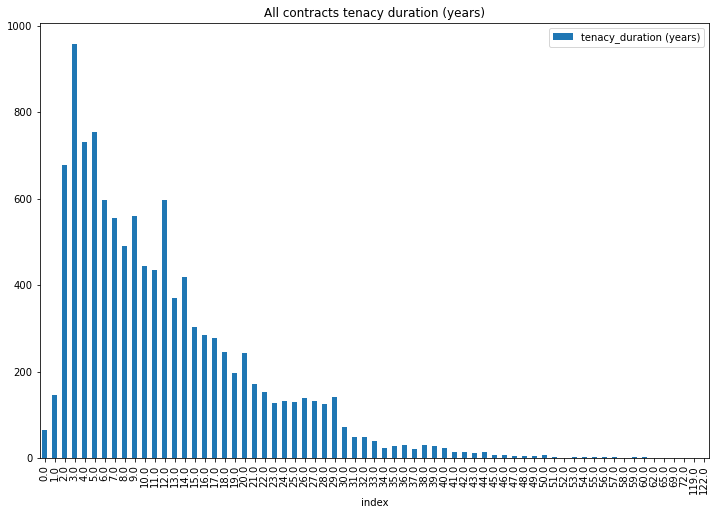

In [12]:
tenacy_data['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "All contracts tenacy duration (years)")

(1698, 11)


<AxesSubplot:title={'center':'Closed contracts tenacy duration (years)'}, xlabel='index'>

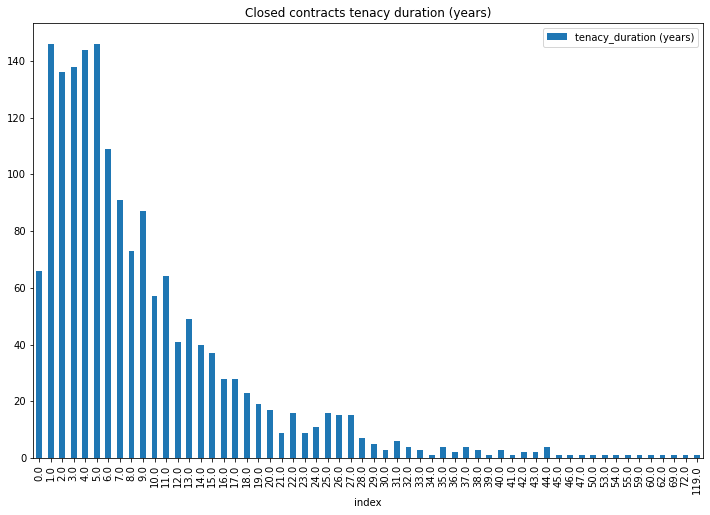

In [13]:
# Closed contracts
closed_contracts = tenacy_data[tenacy_data['Status'] == 'Closed']
print(closed_contracts.shape)
closed_contracts['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "Closed contracts tenacy duration (years)")

(9404, 11)


<AxesSubplot:title={'center':'Open contracts tenacy duration (years)'}, xlabel='index'>

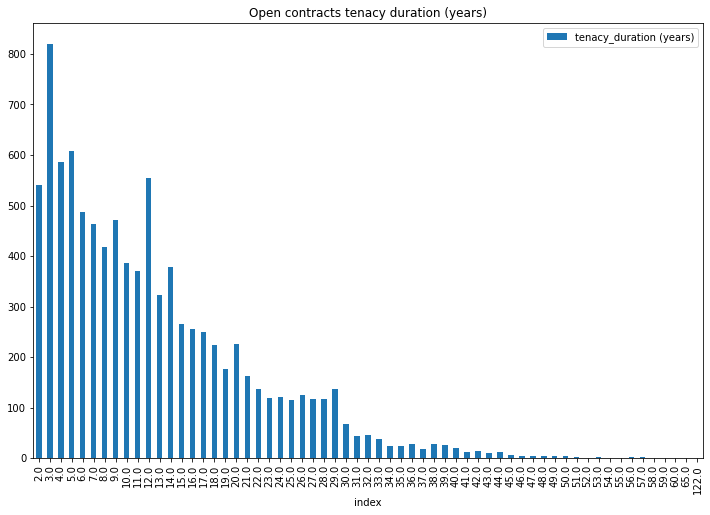

In [14]:
# Open contracts
open_contracts = tenacy_data[tenacy_data['Status'] == 'Open']
print(open_contracts.shape)
open_contracts['tenacy_duration (years)'].value_counts().reset_index().sort_values('index').set_index('index').plot.bar(figsize = (12,8), title = "Open contracts tenacy duration (years)")

# Case data

In [15]:
case_data
# which cases closes more effectively

,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date
0,Case0,Unit8230,2005.0,Resolved,ASB,NaN,21/02/2019 10:20
1,Case1,Unit7377,1880.0,Resolved,Service Charges,Invoice/Breakdown Request,20/05/2019 08:23
2,Case2,Unit2402,2008.0,Resolved,ASB,NaN,20/05/2019 08:47
3,Case3,Unit9567,1935.0,Resolved,Query,NaN,20/05/2019 08:55
4,Case4,Unit7956,2014.0,Resolved,Query,NaN,20/05/2019 09:04
...,...,...,...,...,...,...,...
46296,Case46296,Unit1774,2017.0,Resolved,Query,NaN,17/05/2019 15:26
46297,Case46297,Unit4313,1942.0,Resolved,Income,Account Enquiry,17/05/2019 15:53
46298,Case46298,Unit9834,2013.0,Resolved,Income,Account Enquiry,17/05/2019 15:53
46299,Case46299,Unit38,1988.0,Resolved,Query,NaN,17/05/2019 15:57


In [16]:
case_data['quarter'] = pd.PeriodIndex(case_data.case_create_date, freq='Q')

<AxesSubplot:title={'center':'Cases Trendlines'}, xlabel='quarter'>

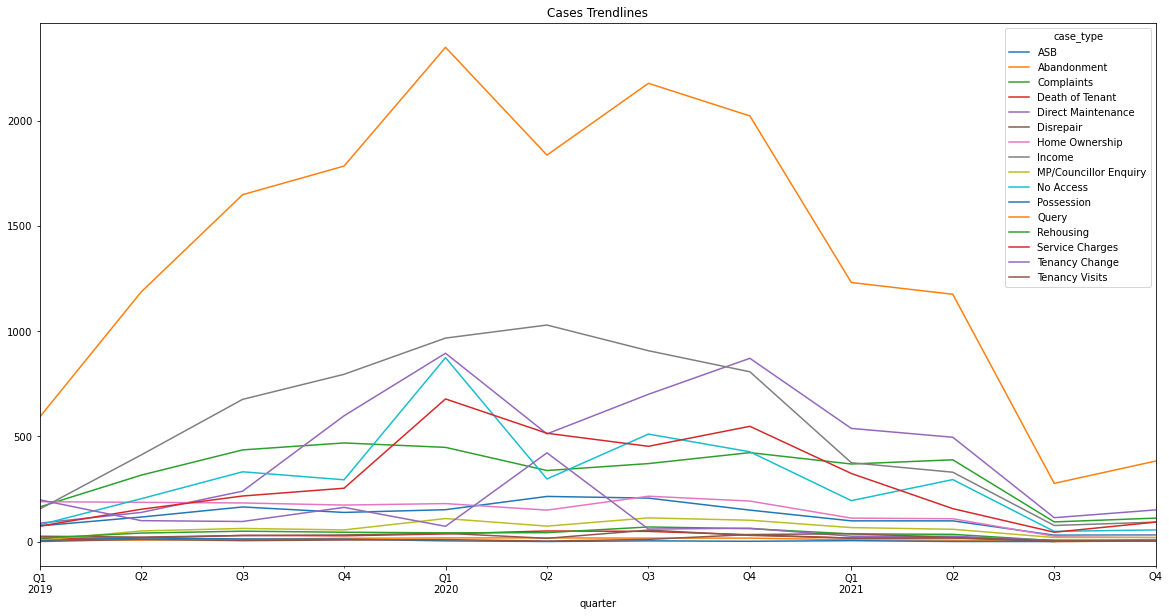

In [17]:
pd.pivot_table(case_data, index='case_type', columns='quarter',values='case_number',aggfunc='count').T.plot(figsize = (20,10), title="Cases Trendlines")

<AxesSubplot:title={'center':'Dump & mould cases'}, xlabel='quarter'>

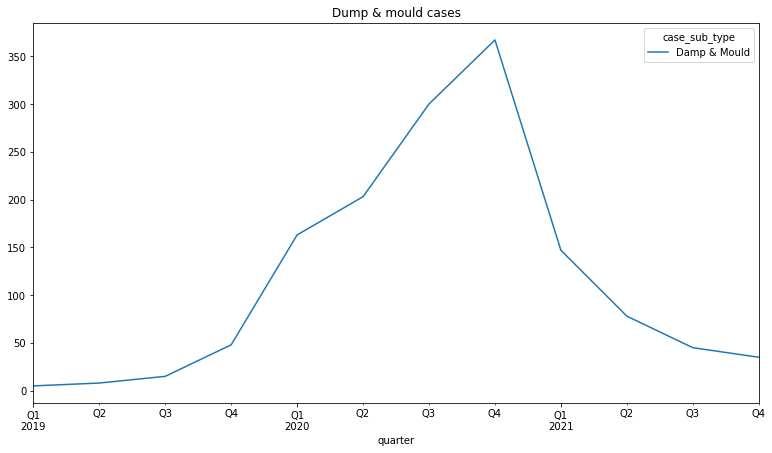

In [18]:
pd.pivot_table(case_data[case_data['case_sub_type'] == 'Damp & Mould'], index='case_sub_type', columns='quarter',values='case_number',aggfunc='count').T.plot(figsize = (13,7), title="Dump & mould cases")

In [19]:
# print(case_data['case_create_date'].min(), case_data['case_create_date'].max())
# case_data['case_type'].value_counts()
# case_data['case_sub_type'].value_counts()

01/02/2019 09:14 31/12/2020 15:08


In [24]:
# Set as closing date the current date for the open contracts so that we can do comparisons with end date
tenacy_data['tenancy_end_date_as_date'] = tenacy_data['tenancy_end_date_as_date'].apply(lambda x : datetime.now() if str(x) == 'NaT' else x)

In [25]:
print(case_data.shape, tenacy_data.shape)
units_cases_df =case_data.merge(tenacy_data, on = 'unit_ref')
units_cases_df = units_cases_df[units_cases_df['case_create_date'] >= units_cases_df['tenancy_start_date_as_date']]
units_cases_df = units_cases_df[units_cases_df['case_create_date'] <= units_cases_df['tenancy_end_date_as_date']]
print(units_cases_df.shape)

(46301, 8) (11102, 11)
(53086, 18)
(45173, 18)


,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date,quarter,tenancy_id,tenancy_start_date,tenancy_end_date,tenancy_start_date_as_date,tenancy_end_date_as_date,Status,tenancy_duration (days),tenacy_duration (months),tenacy_duration (6- months),tenacy_duration (years)
0,Case0,Unit8230,2005.0,Resolved,ASB,NaN,21/02/2019 10:20,2019Q1,Tenant8773,21/08/2017,NaN,2017-08-21,2022-07-25 01:59:03.047898,Open,1799,60.0,10.0,5.0
1,Case97,Unit8230,2005.0,Resolved,ASB,NaN,22/05/2019 07:08,2019Q2,Tenant8773,21/08/2017,NaN,2017-08-21,2022-07-25 01:59:03.047898,Open,1799,60.0,10.0,5.0
2,Case99,Unit8230,2005.0,Resolved,Query,NaN,22/05/2019 07:33,2019Q2,Tenant8773,21/08/2017,NaN,2017-08-21,2022-07-25 01:59:03.047898,Open,1799,60.0,10.0,5.0
3,Case101,Unit8230,2005.0,Resolved,ASB,NaN,22/05/2019 07:59,2019Q2,Tenant8773,21/08/2017,NaN,2017-08-21,2022-07-25 01:59:03.047898,Open,1799,60.0,10.0,5.0
4,Case1027,Unit8230,2005.0,Resolved,Direct Maintenance,OOH / ECO,13/06/2019 13:33,2019Q2,Tenant8773,21/08/2017,NaN,2017-08-21,2022-07-25 01:59:03.047898,Open,1799,60.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53079,Case46108,Unit8101,2018.0,Resolved,Service Charges,Calculation/Apportionment Query,08/05/2019 09:27,2019Q3,Tenant7930,30/08/2018,NaN,2018-08-30,2022-07-25 01:59:03.047229,Open,1425,48.0,8.0,4.0
53080,Case46143,Unit6914,2004.0,Resolved,Service Charges,Calculation/Apportionment Query,10/05/2019 14:21,2019Q4,Tenant3261,06/08/2004,NaN,2004-08-06,2022-07-25 01:59:03.044088,Open,6562,219.0,36.0,18.0
53081,Case46182,Unit1190,NaN,Resolved,Service Charges,Invoice/Breakdown Request,14/05/2019 12:59,2019Q2,Tenant2262,14/05/2004,NaN,2004-05-14,2022-07-25 01:59:03.043441,Open,6646,222.0,37.0,18.0
53083,Case46201,Unit4371,1899.0,Resolved,Income,Direct Debit Enquiry,15/05/2019 09:22,2019Q2,Tenant6001,13/05/2019,NaN,2019-05-13,2022-07-25 01:59:03.045924,Open,1169,39.0,6.0,3.0


In [27]:
units_cases_df['case_create_date_as_date'] = units_cases_df['case_create_date'].apply(lambda x :  datetime.strptime(x, '%d/%m/%Y %H:%M'))
units_cases_df['time_until_the_case (days)'] = units_cases_df.apply(lambda row :( row['case_create_date_as_date'] - row['tenancy_start_date_as_date']).days, axis = 1 )

0         549
1         639
2         639
3         639
4         661
         ... 
53079     251
53080    5390
53081    5478
53083       2
53084    2247
Name: time_until_the_case (days), Length: 45173, dtype: int64

In [29]:
# Merge unit_cases with vulnerability
units_cases_df = units_cases_df.merge(vulnerability_data_packed, on = 'tenancy_id', how= 'left')
units_cases_df['Vulnerability'] = units_cases_df['Vulnerability'].apply(lambda x : x if isinstance(x, list) else ['Healthy'])
units_cases_df['number of vulnerabilities'] = units_cases_df['Vulnerability'].apply(lambda x : len(x))

In [104]:
# print(dnt(units_cases_df.dropna(subset = ['unit_build_year'])['unit_build_year'].mean()))
mean_build_year = int(units_cases_df.dropna(subset = ['unit_build_year'])['unit_build_year'].mean())
units_cases_df['unit_build_year'].fillna(mean_build_year, inplace= True)

In [105]:
units_cases_df['label'] = units_cases_df['case_sub_type'].apply(lambda x : 1 if x == 'Damp & Mould' else 0)
# units_cases_df['label']

In [106]:
# Duplicated case numbers because some tenants are leaving together
units_cases_df[units_cases_df['case_number'].duplicated()]

,case_number,unit_ref,unit_build_year,case_status,case_type,case_sub_type,case_create_date,quarter,tenancy_id,tenancy_start_date,...,Status,tenancy_duration (days),tenacy_duration (months),tenacy_duration (6- months),tenacy_duration (years),case_create_date_as_date,time_until_the_case (days),Vulnerability,number of vulnerabilities,label
15755,Case41027,Unit9707,2015.0,Resolved,Query,NaN,13/11/2019 13:38,2019Q4,Tenant8463,04/11/2019,...,Open,994,33.0,6.0,3.0,2019-11-13 13:38:00,9,[Healthy],1,0
15757,Case41429,Unit9707,2015.0,Resolved,Query,NaN,20/11/2019 11:24,2019Q4,Tenant8463,04/11/2019,...,Open,994,33.0,6.0,3.0,2019-11-20 11:24:00,16,[Healthy],1,0
31596,Case45024,Unit131,1890.0,Resolved,ASB,NaN,21/01/2020 09:43,2020Q1,Tenant7054,20/01/2020,...,Open,917,31.0,5.0,3.0,2020-01-21 09:43:00,1,[Healthy],1,0
34269,Case12553,Unit8541,1974.0,Resolved,Income,Tenancy Enquiry,10/07/2020 15:27,2020Q4,Tenant1492,16/11/2018,...,Open,1347,45.0,7.0,4.0,2020-07-10 15:27:00,602,[Healthy],1,0
34271,Case19118,Unit8541,1974.0,Resolved,Income,Refund Enquiry,05/10/2020 14:02,2020Q2,Tenant1492,16/11/2018,...,Open,1347,45.0,7.0,4.0,2020-10-05 14:02:00,689,[Healthy],1,0
39044,Case17886,Unit9601,2018.0,Resolved,Income,Refund Enquiry,21/09/2020 14:21,2020Q3,Tenant3726,12/11/2018,...,Open,1351,45.0,8.0,4.0,2020-09-21 14:21:00,679,[Healthy],1,0
40208,Case19542,Unit6829,2018.0,Resolved,Income,Refund Enquiry,08/10/2020 11:46,2020Q3,Tenant3107,22/08/2019,...,Open,1068,36.0,6.0,3.0,2020-10-08 11:46:00,413,[Healthy],1,0


# Training - Testing

In [107]:
key = ['case_number', 'tenancy_id']
train_cols = ['unit_build_year', 'tenancy_duration (days)', 'time_until_the_case (days)', 'Vulnerability', 'number of vulnerabilities']
test_cols = ['label']

In [108]:
X = units_cases_df[train_cols]
y = units_cases_df['label']

,unit_build_year,tenancy_duration (days),time_until_the_case (days),Vulnerability,number of vulnerabilities
0,2005.0,1799,549,"[Illness, Mental Health]",2
1,2005.0,1799,639,"[Illness, Mental Health]",2
2,2005.0,1799,639,"[Illness, Mental Health]",2
3,2005.0,1799,639,"[Illness, Mental Health]",2
4,2005.0,1799,661,"[Illness, Mental Health]",2
...,...,...,...,...,...
45168,2018.0,1425,251,[Healthy],1
45169,2004.0,6562,5390,[Healthy],1
45170,1974.0,6646,5478,[Healthy],1
45171,1899.0,1169,2,"[Illness, Elderly]",2


In [109]:
def one_hot_encode_list(df:pd.DataFrame, column:str):
    binarizer = MultiLabelBinarizer().fit(df[column])
    vector_df = pd.DataFrame(binarizer.transform(df[column]), columns=binarizer.classes_)

    return vector_df

In [110]:
X = X.join(one_hot_encode_list(units_cases_df, 'Vulnerability')).drop(columns = ['Vulnerability'])

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [119]:
print(y_train.sum(), y_test.sum())

1006 401


# Classifier

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(data_encoded_extended, y['Sub Clusters labels'], test_size=0.2, random_state=0)
for model in ['LR', 'RF']:
    print(model)
    if model == 'LR':
        classifier = LogisticRegression()
    elif model == 'RF':
        classifier = RandomForestClassifier(random_state=7)


    classifier.fit(X_train, y_train)

    # Accuracy
    y_pred = classifier.predict(X_test)
    print(y_pred.shape)

    # Accuracy
    y_pred = classifier.predict(X_test)
    print('Accuracy of {} classifier on test set: {:.4f}'.format(model, classifier.score(X_test, y_test)))

LR
(13552,)
Accuracy of LR classifier on test set: 0.9704
RF
(13552,)
Accuracy of RF classifier on test set: 0.9612


# Feature Importance

Feature 0: unit_build_year, Score :0.1243
Feature 1: tenancy_duration (days), Score :0.2561
Feature 2: time_until_the_case (days), Score :0.5718
Feature 3: number of vulnerabilities, Score :0.0075
Feature 4: COVID 12wk Shielding, Score :0.0020
Feature 5: COVID Self Isolation, Score :0.0028
Feature 6: Caution, Score :0.0014
Feature 7: Child Protection, Score :0.0000
Feature 8: Domestic Violence, Score :0.0016
Feature 9: Drug/Alcohol, Score :0.0003
Feature 10: Elderly, Score :0.0029
Feature 11: Healthy, Score :0.0023
Feature 12: Hearing, Score :0.0019
Feature 13: Illness, Score :0.0042
Feature 14: Language Support, Score :0.0018
Feature 15: Learning difficulties, Score :0.0021
Feature 16: Mental Health, Score :0.0041
Feature 17: Physical Support, Score :0.0040
Feature 18: Sight, Score :0.0015
Feature 19: Tenancy Support, Score :0.0025
Feature 20: Tenancy Verification, Score :0.0019
Feature 21: Wheelchair Support, Score :0.0027
Feature 22: Young Person, Score :0.0004


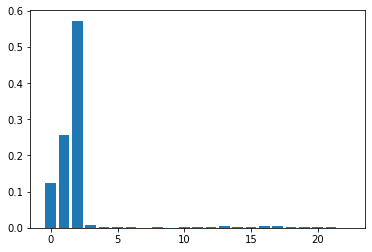

In [154]:
# Random Forest - Feature Importance
from matplotlib import pyplot
importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print("Feature {}: {}, Score :{:.4f}".format(i,X.columns[i],v))
    # print('Feature: {} , Score: %.5f' % (X.columns[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Misclassified data

In [163]:
X_test

,unit_build_year,tenancy_duration (days),time_until_the_case (days),number of vulnerabilities,COVID 12wk Shielding,COVID Self Isolation,Caution,Child Protection,Domestic Violence,Drug/Alcohol,...,Illness,Language Support,Learning difficulties,Mental Health,Physical Support,Sight,Tenancy Support,Tenancy Verification,Wheelchair Support,Young Person
11118,1910.0,1806,977,3,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
11293,1960.0,1022,295,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4157,2013.0,1928,1781,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21261,1999.0,1890,1108,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18046,1960.0,4704,3831,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11462,2019.0,1089,589,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43776,1997.0,6545,5546,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
44624,1990.0,3199,2264,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16381,1974.0,752,25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
test_df = X_test.copy()
test_df['Actual'] = y_test
test_df['Predicted'] = y_pred
test_df[test_df['Actual'] != test_df['Predicted']]

,unit_build_year,tenancy_duration (days),time_until_the_case (days),number of vulnerabilities,COVID 12wk Shielding,COVID Self Isolation,Caution,Child Protection,Domestic Violence,Drug/Alcohol,...,Learning difficulties,Mental Health,Physical Support,Sight,Tenancy Support,Tenancy Verification,Wheelchair Support,Young Person,Actual,Predicted
17874,1964.0,1687,1086,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16274,1997.0,8988,8380,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35011,2006.0,2366,1782,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
22605,2005.0,6006,5216,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9086,1900.0,5439,4901,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30159,1998.0,6125,5392,3,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30078,2014.0,2877,2240,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
7713,1922.0,3906,3347,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12052,1890.0,1274,625,3,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0


In [ ]:
# Which feature impact the maintenance of the building?
# 1. Vulnerability of the tenant (some of them might not allow them to clean the house)
# 2.Number of vulnerabilities that the tenant has
# 3. Duration of tenancy the date that the case is monitored ( not sure how)
# 4. How usual do the tenant use the L&Q apartments - if they do it usually probably they do not create any problems
# 5. Average time that a tenant lives to an apartment
# 6. unit built year (because the case data is just from the last 2 years it make no sense to substract mould_case_date - unit_built_year
# 7. add month of case (summer months, winter months)

# External data that would help:
# Other important info
# I do not see much seasonality (covid related)
# temperature in london
# area of the apartment is missing
# floor of apartent and type of apartment
# how many people are living in the apartment